# TODO
* Xception
* DenseNet
* NasNetLarge

# TODO

# Implementation

## Get images & captions files

In [ ]:
!cp -r drive/MyDrive/LICENTA-DATASET/flickr30k-images.tar.gz .
!tar -xf flickr30k-images.tar.gz
%rm flickr30k-images/readme.txt
!wget https://raw.githubusercontent.com/dima331453/Flickr30k-Romanian/main/flickr30k_romanian.tsv

cp: cannot stat 'drive/MyDrive/LICENTA-DATASET/flickr30k-images.tar.gz': No such file or directory
tar: flickr30k-images.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
rm: cannot remove 'flickr30k-images/readme.txt': No such file or directory
--2024-06-19 08:06:34--  https://raw.githubusercontent.com/dima331453/Flickr30k-Romanian/main/flickr30k_romanian.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25618304 (24M) [text/plain]
Saving to: ‘flickr30k_romanian.tsv’

flickr30k_romanian. 100%[===================>]  24.43M  --.-KB/s    in 0.1s    

2024-06-19 08:06:36 (174 MB/s) - ‘flickr30k_romanian.tsv’ saved [25618304/25618304]



In [ ]:
!cp -r drive/MyDrive/LICENTA-DATASET/flickr30k-images.tar.gz .
!tar -xf flickr30k-images.tar.gz

In [ ]:
%rm flickr30k-images/readme.txt

## Imports

In [ ]:
!pip install keras-self-attention
!pip install evaluate
!pip install sacrebleu
!pip install rouge_score
!pip install git+https://github.com/michelecafagna26/cider.git#egg=cidereval
!pip install vit-keras
!pip install tensorflow-addons

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=f6c5c70c780c916447b09d69e078e7da1564350d380fc02b483de1db4b89dd32
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installa

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import os
from os import listdir, mkdir
import string
from random import shuffle
from collections import defaultdict
import random
from tqdm import tqdm
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.applications import ResNet50, ResNet50V2, InceptionV3, InceptionResNetV2, EfficientNetB4, EfficientNetB7

from keras.models import Sequential
from keras.layers import RandomFlip, RandomRotation, RandomContrast
from keras.layers import Reshape, Bidirectional, Flatten
from keras.models import Model
from keras.layers import Input, Embedding, Dropout, Dense
from keras.layers import LSTM, GRU
from keras.layers import Attention, AdditiveAttention
from keras_self_attention import SeqSelfAttention
from keras.layers import add, concatenate

from keras.callbacks import ModelCheckpoint, Callback
from keras.optimizers import Adam

from keras.utils import plot_model

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import evaluate
from cidereval import cider, ciderD

from vit_keras import vit, utils

bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")
ter = evaluate.load("ter")
rouge = evaluate.load("rouge")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Constants

In [ ]:
IMAGES_PATH = "flickr30k-images"
CAPTIONS_PATH = "./flickr30k_romanian.tsv"

MODELS = ["ResNet50", "ResNet50V2", "InceptionV3", "InceptionResNetV2", "EfficientNetB4", "EfficientNetB7", "VitB16"]
MODEL_NAME = "ResNet50" # @param ["ResNet50", "ResNet50V2", "InceptionV3", "InceptionResNetV2", "EfficientNetB4", "EfficientNetB7", "VitB16"]
MODELS_BASE = "./Models/"
FEATURES_BASE = "/features/"
TRAIN_BASE = "/train"
CONFIG_BASE = "/1/"
UTILS_BASE = "utils/"

FEATURES_PATH = MODELS_BASE + MODEL_NAME + FEATURES_BASE
CP_PATH = MODELS_BASE + MODEL_NAME + TRAIN_BASE + CONFIG_BASE

TOKENIZER_PATH = MODELS_BASE + UTILS_BASE + 'tokenizer.pkl'
DESCRIPTIONS_PATH = MODELS_BASE + UTILS_BASE + 'descriptions.txt'
TRAIN_PATH = MODELS_BASE + UTILS_BASE + 'train.txt'
VALID_PATH = MODELS_BASE + UTILS_BASE + 'valid.txt'
TEST_PATH = MODELS_BASE + UTILS_BASE + 'test.txt'

In [ ]:
IMAGE_SIZE = (380, 380)
IMAGE_AUGMENTATION = Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.2),
        RandomContrast(0.3),
    ]
)

LR = 3e-4

EMBED_DIM = 128 # @param ["128", "256", "512"] {type:"raw"}
FF_DIM = 256 # @param ["128", "256", "512"] {type:"raw"}
LSTM_DIM = 256 # @param ["128", "256", "512"] {type:"raw"}
GRU_DIM = 256 # @param ["128", "256", "512"] {type:"raw"}
BATCH_SIZE = 32 # @param ["32", "64", "128"] {type:"raw"}
EPOCHS = 10
DROPOUT = 0.3


# VOCAB_SIZE = 10000
SEQ_LENGTH = 25
WORD_THRESHOLD = 5

In [ ]:
mkdir(MODELS_BASE)
mkdir(MODELS_BASE + UTILS_BASE)
for model in MODELS:
  mkdir(MODELS_BASE + model)
  mkdir(MODELS_BASE + model + FEATURES_BASE)
  mkdir(MODELS_BASE + model + TRAIN_BASE)
  mkdir(MODELS_BASE + model + TRAIN_BASE + CONFIG_BASE)

## Captions preprocessing

In [ ]:
def load_descriptions(filename):
    file = open(filename, 'r')
    doc = file.read()
    file.close()

    mapping = dict()
    first = True
    for line in doc.split('\n'):
        if first:
          first = False
          continue
        tokens = line.split('\t')
        if len(line) < 4:
            continue


        image_id, image_desc = tokens[1], tokens[3:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)

        if image_id not in mapping:
            mapping[image_id] = list()

        mapping[image_id].append(image_desc)
    return mapping

def clean_descriptions(descriptions, seq_len, word_threshold):
    # prepare translation table for removing punctuation

    length_counts = {}

    word_counts = defaultdict(int)

    table = str.maketrans('', '', r'!"#$%&\'()*+, ./:;<=>?@[]^_`{|}~0123456789„”ü€ñéäł→èûë')
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower().replace("ş", "ș").replace("ţ", "ț") for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove tokens with numbers in them
            original_length = len(desc)

            if original_length in length_counts:
                length_counts[original_length] += 1
            else:
                length_counts[original_length] = 1

            for word in desc[:seq_len]:
                word_counts[word] += 1

    plot_word_occurrence_distribution(word_counts)
    plot_length_distribution(length_counts)
    #####
    first = 5
    table = str.maketrans('', '', r'!"#$%&\'()*+, ./:;<=>?@[]^_`{|}~0123456789„”ü€ñéäł→èûë')
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower().replace("ş", "ș").replace("ţ", "ț") for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            desc_backup = list(desc)
            desc = [word if word_counts[word] >= word_threshold else 'unk' for word in desc]

            # store as string
            desc_list[i] =  'startseq ' + ' '.join(desc[:seq_len]) + ' endseq'

            if 'unk' in desc_list[i] and first > 0:
              print(desc_list[i])
              print(desc_backup)
              first -=  1


def plot_length_distribution(length_counts):
    # Convert the length_counts dictionary to two lists: one for lengths and one for counts
    lengths = list(length_counts.keys())
    counts = list(length_counts.values())

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.bar(lengths, counts, width=0.8, color='blue')
    plt.xlabel('Original Length of Descriptions (number of words)')
    plt.ylabel('Count')
    plt.title('Distribution of Original Description Lengths')
    plt.show()

def plot_word_occurrence_distribution(word_counts):
    # Create a list to store the number of words that occur at least 1, 2, ..., 5 times
    occurrence_counts = [0] * 10

    for count in word_counts.values():
        for i in range(10):
            if count > i:
                occurrence_counts[i] += 1

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, 11), occurrence_counts, width=0.8, color='green')
    plt.xlabel('Word Occurrence Threshold')
    plt.ylabel('Number of Words')
    plt.title('Word Occurrence Distribution')
    plt.xticks(range(1, 11), ['1+', '2+', '3+', '4+', '5+','6+', '7+', '8+', '9+', '10+'])
    plt.show()


def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer(filters='!"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(lines)
    return tokenizer

## Model variants

### GRU + CONCATENATE

In [ ]:
def define_model_GRU_CONC(vocab_size, max_length, in_shape, embed_dim, ff_dim, gru_dim, dropout):
    inputs1 = Input(shape=(in_shape,))
    fe1 = Dropout(dropout)(inputs1)
    fe2 = Dense(ff_dim, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embed_dim, mask_zero=True)(inputs2)
    se2 = Dropout(dropout)(se1)
    se3 = GRU(gru_dim)(se2)

    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(ff_dim, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    return model

### GRU + ADD

In [ ]:
def define_model_GRU_ADD(vocab_size, max_length, in_shape, embed_dim, ff_dim, gru_dim, dropout):
    inputs1 = Input(shape=(in_shape,))
    fe1 = Dropout(dropout)(inputs1)
    fe2 = Dense(ff_dim, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embed_dim, mask_zero=True)(inputs2)
    se2 = Dropout(dropout)(se1)
    se3 = GRU(gru_dim)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(ff_dim, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    return model

### LSTM + CONCATENATE

In [ ]:
def define_model_LSTM_CONC(vocab_size, max_length, in_shape, embed_dim, ff_dim, lstm_dim, dropout):
    inputs1 = Input(shape=(in_shape,))
    fe1 = Dropout(dropout)(inputs1)
    fe2 = Dense(ff_dim, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embed_dim, mask_zero=True)(inputs2)
    se2 = Dropout(dropout)(se1)
    se3 = LSTM(lstm_dim)(se2)

    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(ff_dim, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    return model

### LSTM + ADD

In [ ]:
def define_model_LSTM_ADD(vocab_size, max_length, in_shape, embed_dim, ff_dim, lstm_dim, dropout):
    inputs1 = Input(shape=(in_shape,))
    fe1 = Dropout(dropout)(inputs1)
    fe2 = Dense(ff_dim, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embed_dim, mask_zero=True)(inputs2)
    se2 = Dropout(dropout)(se1)
    se3 = LSTM(lstm_dim)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(ff_dim, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    return model

### GRU + ATT Luong + CONCATENATE

In [ ]:
def define_model_GRU_ATTLuong_CONC(vocab_size, max_length, in_shape, embed_dim, ff_dim, gru_dim, dropout):

    inputs1 = Input(shape=(in_shape,))
    fe1 = Dropout(dropout)(inputs1)
    fe2 = Dense(ff_dim, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embed_dim, mask_zero=True)(inputs2)
    se2 = Dropout(dropout)(se1)
    se3 = Bidirectional(GRU(gru_dim, return_sequences=True))(se2)
    se4 = SeqSelfAttention(attention_type="multiplicative")(se3)
    se5 = Flatten()(se4)
    se6 = Dense(ff_dim, activation='relu')(se5)

    decoder1 = concatenate([fe2, se6])
    decoder2 = Dense(ff_dim, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    return model

### LSTM + ATT Luong + CONCATENATE

In [ ]:
def define_model_LSTM_ATTLuong_CONC(vocab_size, max_length, in_shape, embed_dim, ff_dim, lstm_dim, dropout):

    inputs1 = Input(shape=(in_shape,))
    fe1 = Dropout(dropout)(inputs1)
    fe2 = Dense(ff_dim, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embed_dim, mask_zero=True)(inputs2)
    se2 = Dropout(dropout)(se1)
    se3 = Bidirectional(LSTM(lstm_dim, return_sequences=True))(se2)
    se4 = SeqSelfAttention(attention_type="multiplicative")(se3)
    se5 = Flatten()(se4)
    se6 = Dense(ff_dim, activation='relu')(se5)

    decoder1 = concatenate([fe2, se6])
    decoder2 = Dense(ff_dim, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    return model

### GRU + ATT Bahdanau + CONCATENATE

In [ ]:
def define_model_GRU_ATTBahdanau_CONC(vocab_size, max_length, in_shape, embed_dim, ff_dim, gru_dim, dropout):

    inputs1 = Input(shape=(in_shape,))
    fe1 = Dropout(dropout)(inputs1)
    fe2 = Dense(ff_dim, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embed_dim, mask_zero=True)(inputs2)
    se2 = Dropout(dropout)(se1)
    se3 = Bidirectional(GRU(gru_dim, return_sequences=True))(se2)
    se4 = SeqSelfAttention(attention_type="additive")(se3)
    se5 = Flatten()(se4)
    se6 = Dense(ff_dim, activation='relu')(se5)

    decoder1 = concatenate([fe2, se6])
    decoder2 = Dense(ff_dim, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    return model

### LSTM + ATT Bahdanau + CONCATENATE

In [ ]:
def define_model_LSTM_ATTBahdanau_CONC(vocab_size, max_length, in_shape, embed_dim, ff_dim, lstm_dim, dropout):

    inputs1 = Input(shape=(in_shape,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(ff_dim, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embed_dim, mask_zero=True)(inputs2)
    se2 = Dropout(dropout)(se1)
    se3 = Bidirectional(LSTM(lstm_dim, return_sequences=True))(se2)
    se4 = SeqSelfAttention(attention_type="additive")(se3)
    se5 = Flatten()(se4)
    se6 = Dense(ff_dim, activation='relu')(se5)

    decoder1 = concatenate([fe2, se6])
    decoder2 = Dense(ff_dim, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    return model

## Model functions

In [ ]:
def define_model(vocab_size, max_length, in_shape, embed_dim, ff_dimm, lstm_or_gru_dim, dropout, variant = "v1"):
    if variant == "v1":
      model = define_model_LSTM_ADD(vocab_size, max_length, in_shape, embed_dim, ff_dimm, lstm_or_gru_dim, dropout)
    elif variant == "v2":
      model = define_model_LSTM_CONC(vocab_size, max_length, in_shape, embed_dim, ff_dimm, lstm_or_gru_dim, dropout)
    elif variant == "v3":
      model = define_model_GRU_ADD(vocab_size, max_length, in_shape, embed_dim, ff_dimm, lstm_or_gru_dim, dropout)
    elif variant == "v4":
      model = define_model_GRU_CONC(vocab_size, max_length, in_shape, embed_dim, ff_dimm, lstm_or_gru_dim, dropout)
    elif variant == "v5":
      model = define_model_GRU_ATTLuong_CONC(vocab_size, max_length, in_shape, embed_dim, ff_dimm, lstm_or_gru_dim, dropout)
    elif variant == "v6":
      model = define_model_LSTM_ATTLuong_CONC(vocab_size, max_length, in_shape, embed_dim, ff_dimm, lstm_or_gru_dim, dropout)
    elif variant == "v7":
      model = define_model_GRU_ATTBahdanau_CONC(vocab_size, max_length, in_shape, embed_dim, ff_dimm, lstm_or_gru_dim, dropout)
    elif variant == "v8":
      model = define_model_LSTM_ATTBahdanau_CONC(vocab_size, max_length, in_shape, embed_dim, ff_dimm, lstm_or_gru_dim, dropout)
    else:
      model = None
    # model.summary()
    plot_model(model, to_file=f'model_{variant}.png', show_shapes=True)

    return model

def get_cnn_model(model_name):
    model = None

    if model_name == "ResNet50":
      model = ResNet50()
    elif model_name == "ResNet50V2":
      model = ResNet50V2()
    elif model_name == "InceptionV3":
      model = InceptionV3()
    elif model_name == "InceptionResNetV2":
      model = InceptionResNetV2()
    elif model_name == "EfficientNetB4":
      model = EfficientNetB4()
    elif model_name == "EfficientNetB7":
      model = EfficientNetB7()
    else:
      model = None

    model.trainable = False
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output) #  put -2
    # model.summary()

    return model, model.layers[-1].output_shape[-1]

def get_vit_model():

    model = vit.vit_b16(
        activation='sigmoid',
        pretrained=True,
        include_top=True,
        pretrained_top=True
    )

    model.trainable = False
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output) #  put -2
    # model.summary()

    return model, model.layers[-1].output_shape[-1]

## Dataset generator

In [ ]:
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    seqs = tokenizer.texts_to_sequences(desc_list)
    for seq in seqs:
      for i in range(1, len(seq)):
          # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          # store
          X1.append(photo)
          X2.append(in_seq)
          y.append(out_seq)

    return np.array(X1), np.array(X2), np.array(y)

def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # img = img_aug(img)
    return img

def augment_and_extract_features(img, img_aug):
    img = img_aug(img)
    return cnn_model(img)

def process_input(img_path, key):
    return preprocess_image(img_path), key

def data_generator(descriptions, cnn_model, tokenizer, max_length, batch_size, directory, img_aug, vocab_size):
    image_paths = [os.path.join(directory, key + '.jpg') for key in descriptions.keys()]

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, list(descriptions.keys())))
    dataset = dataset.map(process_input, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    dataset = dataset.repeat()


    for batch_images, batch_keys in dataset:
        img_features = augment_and_extract_features(batch_images, img_aug)
        batch_keys = [key.decode('utf-8') for key in batch_keys.numpy()]  # Convert bytes to string
        photos = {key: feature for key, feature in zip(batch_keys, img_features.numpy())}
        in_img_batch, in_seq_batch, out_word_batch = [], [], []

        for key in batch_keys:
            desc_list = descriptions[key]
            photo = photos[key]  # Adjust to remove the extra dimension
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)

            in_img_batch.append(in_img)
            in_seq_batch.append(in_seq)
            out_word_batch.append(out_word)

        yield [[np.vstack(in_img_batch), np.vstack(in_seq_batch)], np.vstack(out_word_batch)]

# Prepare for training

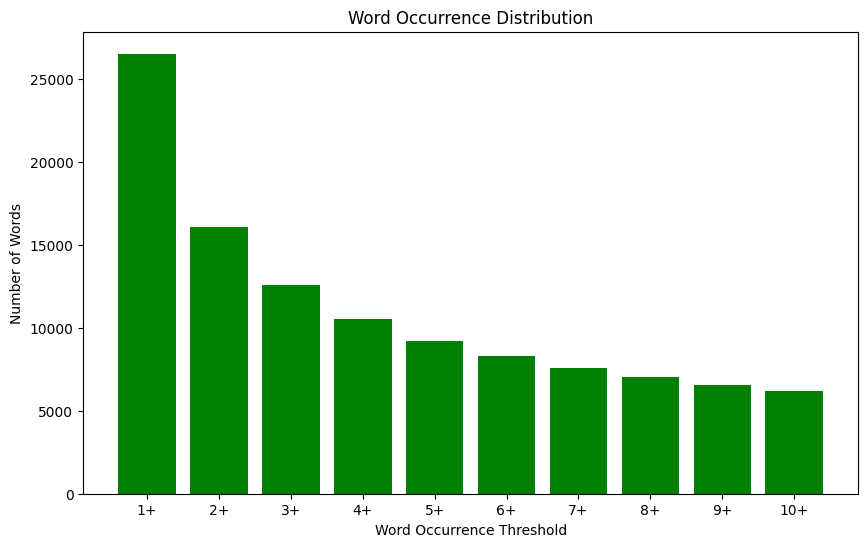

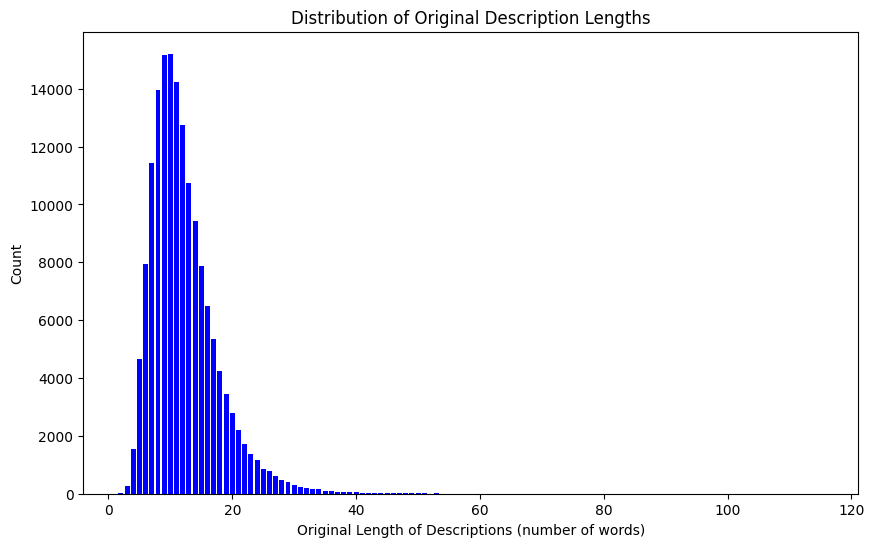

startseq doi tineri bărbați albi sunt afară lângă multe unk endseq
['doi', 'tineri', 'bărbați', 'albi', 'sunt', 'afară', 'lângă', 'multe', 'tufe']
startseq două persoane din fotografie se joacă la chitară iar cealaltă îl unk endseq
['două', 'persoane', 'din', 'fotografie', 'se', 'joacă', 'la', 'chitară', 'iar', 'cealaltă', 'îl', 'ciupește']
startseq un bărbat asiatic în costum neagru stă lângă o femeie cu păr întunecat și o femeie cu păr unk endseq
['un', 'bărbat', 'asiatic', 'în', 'costum', 'neagru', 'stă', 'lângă', 'o', 'femeie', 'cu', 'păr', 'întunecat', 'și', 'o', 'femeie', 'cu', 'păr', 'saten']
startseq cinci balerine unk în mijlocul unei sărituri într-un studio de dans cu soarele unk printr-o fereastră endseq
['cinci', 'balerine', 'surprinse', 'în', 'mijlocul', 'unei', 'sărituri', 'într-un', 'studio', 'de', 'dans', 'cu', 'soarele', 'pătrunzând', 'printr-o', 'fereastră']
startseq cinci fete dansează și își unk picioarele într-o clasă de balet endseq
['cinci', 'fete', 'dansează', '

In [ ]:
descriptions = load_descriptions(CAPTIONS_PATH)
clean_descriptions(descriptions, SEQ_LENGTH, WORD_THRESHOLD)
vocabulary = to_vocabulary(descriptions)

all_items = list(descriptions.keys())
np.random.seed(42)
random.seed(42)
random.shuffle(all_items)
print(list(all_items)[:10])

train_items = set(all_items[:-5000])
train_descriptions =  {key: value for key, value in descriptions.items() if key in train_items}

test_items = set(all_items[-5000:])
test_descriptions =  {key: value for key, value in descriptions.items() if key in test_items}

tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
print(list(train_items)[:10])

['1246239396', '3471173526', '337605969', '2667015110', '277119391', '2837808847', '310030981', '6882870726', '2900048238', '5615654150']


In [ ]:
for word, index in tokenizer.word_index.items():
  print(word)
  if index >= 25:
    break

startseq
endseq
un
o
în
de
pe
cu
și
se
care
unk
la
bărbat
femeie
într-o
ce
doi
timp
stă
cămașă
oameni
om
într-un
lângă


In [ ]:
VARIANT = "v1"  # @param ["v1", "v2", "v3", "v4", "v5", "v6", "v7", "v8"]
MODEL_NAME = "InceptionResNetV2" # @param ["ResNet50", "ResNet50V2", "InceptionV3", "InceptionResNetV2", "EfficientNetB4", "EfficientNetB7", "VitB16"]

cnn_model, out_shape = get_cnn_model(MODEL_NAME)
print(out_shape)
model = define_model(
    vocab_size,
    SEQ_LENGTH + 2,
    out_shape,
    EMBED_DIM,
    FF_DIM,
    LSTM_DIM,
    DROPOUT,
    variant = VARIANT)

train_generator = data_generator(train_descriptions,
                                 cnn_model,
                                 tokenizer,
                                 SEQ_LENGTH + 2,
                                 BATCH_SIZE,
                                 IMAGES_PATH,
                                 IMAGE_AUGMENTATION,
                                 vocab_size)
test_generator = data_generator(test_descriptions,
                                 cnn_model,
                                 tokenizer,
                                 SEQ_LENGTH + 2,
                                 BATCH_SIZE,
                                 IMAGES_PATH,
                                 IMAGE_AUGMENTATION,
                                 vocab_size)

225209952/225209952 [==============================] - 11s 0us/step
1536


#Caption generation

In [ ]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    # Seed the generation process
    in_text = 'startseq'
    # Iterate over the whole length of the sequence
    for i in range(max_length):
        # Encode the input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad input sequence
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Predict next word
        yhat = model.predict([photo, sequence], verbose=0)  # Reshape photo to match expected shape #photo.reshape(1, -1)
        # Convert probability to integer
        yhat = np.argmax(yhat)
        # Map integer to word
        word = word_for_id(yhat, tokenizer)
        # Stop if we cannot map the word or if we predict the end of the sequence
        if word is None or word == 'endseq':
            break
        # Append the predicted word to the input for generating the next word
        in_text += ' ' + word
    return in_text.replace("startseq ", "").replace(" endseq", "")

def generate_desc_batch(model, tokenizer, photos, max_length):
    batch_size = len(photos)
    in_texts = ['startseq'] * batch_size
    completed_descriptions = [''] * batch_size
    for i in range(max_length):
        sequences = tokenizer.texts_to_sequences(in_texts)
        sequences = pad_sequences(sequences, maxlen=max_length)
        yhat = model.predict([photos, sequences], verbose=0)
        yhat = np.argmax(yhat, axis=1)
        words = [word_for_id(y, tokenizer) for y in yhat]

        for j in range(batch_size):
            word = words[j]
            if word is None or word == 'endseq':
                continue
            in_texts[j] += ' ' + word
            completed_descriptions[j] = in_texts[j]

    completed_descriptions = [desc.replace("startseq ", "").replace(" endseq", "") for desc in completed_descriptions]
    return completed_descriptions

def batch_process_images(model, tokenizer, image_paths, batch_size, max_length):
    descriptions = []
    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i + batch_size]
        photo_batch = [preprocess_image(path) for path in batch_paths]
        photo_features_batch = np.array([cnn_model(np.expand_dims(photo, axis=0)) for photo in photo_batch])
        photo_features_batch = np.squeeze(photo_features_batch, axis=1)
        batch_descriptions = generate_desc_batch(model, tokenizer, photo_features_batch, max_length)
        descriptions.extend(batch_descriptions)
    return descriptions

def beam_search_batch(model, tokenizer, photos, max_length, beam_width):
    batch_size = len(photos)
    start_seq = [tokenizer.texts_to_sequences(['startseq'])[0]] * batch_size
    sequences = [[[seq, 0.0]] for seq in start_seq]

    for _ in range(max_length):
        all_candidates = [[] for _ in range(batch_size)]

        for b in range(batch_size):
            for seq, score in sequences[b]:
                if seq[-1] == tokenizer.word_index['endseq']:
                    all_candidates[b].append([seq, score])
                    continue

                yhat = model.predict([np.expand_dims(photos[b], axis=0), pad_sequences([seq], maxlen=max_length)], verbose=0)
                top_words = np.argsort(yhat[0])[-beam_width:]

                for word in top_words:
                    new_seq = seq + [word]
                    new_score = score - np.log(yhat[0][word])
                    all_candidates[b].append([new_seq, new_score])

        sequences = []
        for b in range(batch_size):
            ordered = sorted(all_candidates[b], key=lambda tup: tup[1])
            sequences.append(ordered[:beam_width])

    final_sequences = [seq[0][0] for seq in sequences]
    descriptions = []
    for seq in final_sequences:
        desc = ' '.join([word_for_id(word, tokenizer) for word in seq if word != 0])
        descriptions.append(desc.replace("startseq ", "").replace(" endseq", ""))

    return descriptions

def batch_process_images_beam(model, tokenizer, image_paths, batch_size, max_length, bw):
    descriptions = []
    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i + batch_size]
        photo_batch = [preprocess_image(path) for path in batch_paths]
        photo_features_batch = np.array([cnn_model(np.expand_dims(photo, axis=0)) for photo in photo_batch])
        photo_features_batch = np.squeeze(photo_features_batch, axis=1)
        batch_descriptions = beam_search_batch(model, tokenizer, photo_features_batch, max_length, bw)
        descriptions.extend(batch_descriptions)
    return descriptions

# Training

# VERIFICA DACA IncV3 e bun la instantiere

In [ ]:
df_results = pd.DataFrame()

VARIANTS = ["v4"]
MODEL_NAME = "EfficientNetB4" # ["ResNet50", "ResNet50V2", "InceptionV3", "InceptionResNetV2", "EfficientNetB4", "EfficientNetB7", "VitB16"]

for variant in VARIANTS:
  cnn_model, out_shape = get_cnn_model(MODEL_NAME)
  # cnn_model, out_shape = get_vit_model()
  print(out_shape)
  model = define_model(
      vocab_size,
      SEQ_LENGTH + 2,
      out_shape,
      EMBED_DIM,
      FF_DIM,
      LSTM_DIM,
      DROPOUT,
      variant = variant)

  train_generator = data_generator(train_descriptions,
                                  cnn_model,
                                  tokenizer,
                                  SEQ_LENGTH + 2,
                                  BATCH_SIZE,
                                  IMAGES_PATH,
                                  IMAGE_AUGMENTATION,
                                  vocab_size)
  test_generator = data_generator(test_descriptions,
                                  cnn_model,
                                  tokenizer,
                                  SEQ_LENGTH + 2,
                                  BATCH_SIZE,
                                  IMAGES_PATH,
                                  IMAGE_AUGMENTATION,
                                  vocab_size)


  class PrintDescCallback(Callback):
      def on_epoch_begin(self, epoch, logs=None):
          img_path = f'./flickr30k-images/{list(test_descriptions.keys())[0]}.jpg'
          photo_features = cnn_model(np.expand_dims(preprocess_image(img_path), axis=0))
          desc = generate_desc(self.model, tokenizer, photo_features, SEQ_LENGTH + 2)
          print("Start epoch {} of training =>".format(epoch))
          print("ORG: {}".format(test_descriptions[list(test_descriptions.keys())[0]][0].replace("startseq ", "").replace(" endseq", "")))
          print("GEN: {}".format(desc))

      def on_train_end(self, epoch, logs=None):
          img_path = f'./flickr30k-images/{list(test_descriptions.keys())[0]}.jpg'
          photo_features = cnn_model(np.expand_dims(preprocess_image(img_path), axis=0))
          desc = generate_desc(self.model, tokenizer, photo_features, SEQ_LENGTH + 2)
          print("Start epoch {} of training =>".format(epoch))
          print("ORG: {}".format(test_descriptions[list(test_descriptions.keys())[0]][0].replace("startseq ", "").replace(" endseq", "")))
          print("GEN: {}".format(desc))


  steps_per_epoch = len(train_descriptions) // BATCH_SIZE
  validation_steps = len(test_descriptions) // BATCH_SIZE;
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=LR), metrics=['accuracy'])
  checkpoint = ModelCheckpoint('./drive/MyDrive/LICENTA-MODELS/' + MODEL_NAME + '-' + variant + '-{epoch:02d}.tf', monitor='val_loss', verbose=1, save_best_only=False, mode='min')

  model.fit(
      train_generator,
      validation_data = test_generator,
      epochs = EPOCHS,
      verbose = 1,
      callbacks = [checkpoint, PrintDescCallback()],
      steps_per_epoch = steps_per_epoch,
      validation_steps = validation_steps,
      validation_freq = 1
  )


  image_paths = [os.path.join(IMAGES_PATH, key + '.jpg') for key in test_descriptions.keys()]
  preds = batch_process_images(model, tokenizer, image_paths, 64, SEQ_LENGTH + 2)

  refs = []
  for descs in list(test_descriptions.values()):
    new_descs = []
    for desc in descs:
      new_descs.append(desc.replace("startseq ", "").replace(" endseq", ""))
    refs.append(new_descs)


  results = bleu.compute(predictions=preds, references=refs)
  b1, b2, b3, b4 = results['precisions']
  results = meteor.compute(predictions=preds, references=refs)
  met = results['meteor']
  results = ter.compute(predictions=preds, references=refs)
  te = results['score']
  results = rouge.compute(predictions=preds, references=refs)
  rougeL, r1, r2 = results['rougeL'], results['rouge1'], results['rouge2']
  results = cider(predictions=preds, references=refs, df='corpus')
  cid = results['avg_score']

  new_data = pd.DataFrame({'model': [f"{MODEL_NAME}-{variant}"],
                          'B-1': [b1], 'B-2': [b2], 'B-3': [b3], 'B-4': [b4],
                          'CIDEr': [cid], 'R-1': [r1], 'R-2': [r2], 'Rouge-L': [rougeL], 'Meteor': [met], 'TER': [te]})

  df_results = pd.concat([df_results, new_data], ignore_index=True)
  print(df_results)

78864416/78864416 [==============================] - 3s 0us/step
1792
Start epoch 0 of training =>
ORG: un bărbat cu haine reflectorizante și protecție auditivă conduce un tractor john deere pe o stradă
GEN: stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri stiluri
Epoch 1/10
836/836 [==============================] - ETA: 0s - loss: 4.9024 - accuracy: 0.1883
Epoch 1: saving model to ./drive/MyDrive/LICENTA-MODELS/EfficientNetB4-v4-01.tf
836/836 [==============================] - 747s 888ms/step - loss: 4.9024 - accuracy: 0.1883 - val_loss: 3.9362 - val_accuracy: 0.2667
Start epoch 1 of training =>
ORG: un bărbat cu haine reflectorizante și protecție auditivă conduce un tractor john deere pe o stradă
GEN: un om în cămașă albastră și o cămașă albastră și o cămașă albastră și o cămașă albastră și o cămașă albastră și o cămașă albast

100%|██████████| 79/79 [27:58<00:00, 21.25s/it]


               model       B-1       B-2       B-3       B-4     CIDEr  \
0  EfficientNetB4-v4  0.497505  0.197571  0.081486  0.032196  0.428066   

        R-1       R-2   Rouge-L    Meteor        TER  
0  0.395774  0.195959  0.353011  0.323665  88.994212  


In [ ]:
import pickle
# saving
with open('./drive/MyDrive/LICENTA-MODELS/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
cnn_model, out_shape = get_cnn_model("EfficientNetB4")
model = define_model(
    vocab_size,
    SEQ_LENGTH + 2,
    out_shape,
    EMBED_DIM,
    FF_DIM,
    LSTM_DIM,
    DROPOUT,
    variant = "v4")

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=LR), metrics=['accuracy'])
model.load_weights('./drive/MyDrive/LICENTA-MODELS/EfficientNetB4-v4-10.tf')

78864416/78864416 [==============================] - 1s 0us/step
